<a href="https://colab.research.google.com/github/ninja-codes-droid/Machine_learning_project/blob/master/Live_mask_detection_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Live Mask Detection using Deep Learning - Convolutional Neural Network**

##Importing Libraries 

In [1]:
import numpy as np # For Data processing
import tensorflow.keras as tk  # For Model processing 
import seaborn as sns  # Python data visualization library based on matplotlib
import matplotlib.pyplot as plt  # For Data Visualization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For Data Preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

## Data Acquisition
###### This is a face mask detection dataset from kaggle authored by ashishjangra27 (https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset) ,The dataset contains two classes of images ( withmask and withoutmask) .


###Downloading Dataset from Kaggle


In [4]:
!pip install kaggle         #Install Kaggle python library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Mount Google drive to store credentials of kaggle for future use 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Make a temporary location to store the Kaggle Cred for this instance
! mkdir ~/.kaggle

In [7]:
# Copy the Cred from google drive to the temporary location 
! cp /content/drive/MyDrive/Colab\ Notebooks/Kaggle\ cred/kaggle.json ~/.kaggle/kaggle.json
# Changing permission to owner only
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Downloading Dataset from kaggle
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset

 95% 313M/330M [00:04<00:00, 91.8MB/s]
100% 330M/330M [00:04<00:00, 76.4MB/s]


In [ ]:
#Unzipping the Dataset 
! unzip /content/face-mask-12k-images-dataset.zip

### Data Preprocessing 

In [2]:
# Assigning image folders to the corrosponding variables 
train_dataset_path = '/content/Face Mask Dataset/Train'
validation_dataset_path = '/content/Face Mask Dataset/Validation'

In [10]:
# Generating more images using below parameters
training_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40,
                                                                                            width_shift_range = 0.2,
                                                                                            height_shift_range = 0.2,
                                                                                            shear_range = 0.2,
                                                                                            zoom_range = 0.2,
                                                                                            horizontal_flip = True,
                                                                                            fill_mode = 'nearest'
                                                                  )
# This generator reads images from train dataset and 
# create batches of augmented image data 

training_data  = training_datagen.flow_from_directory(train_dataset_path,target_size=(200,200),batch_size = 128,class_mode = 'binary')   

Found 10000 images belonging to 2 classes.


In [13]:
# To display assigned values to classes 
training_data.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [ ]:
#Show augmented images 
def plotImages(image_arr):
    fig, axes  = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
          ax.imshow(img)
    plt.tight_layout()
    plt.show()

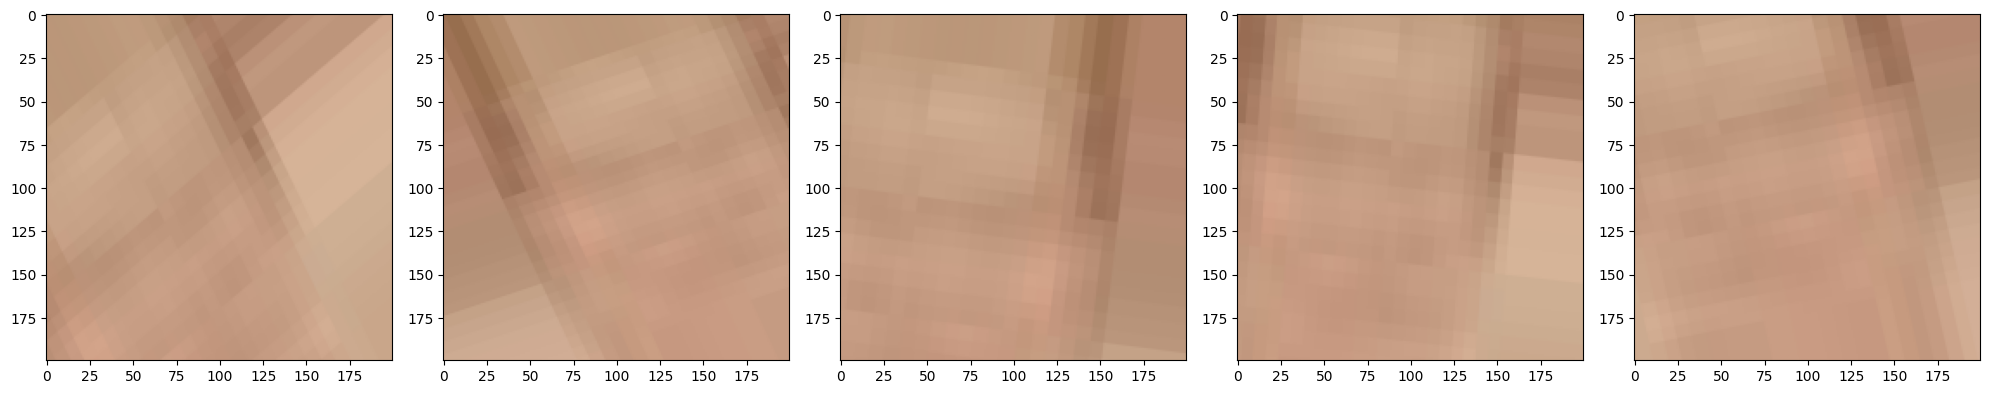

In [ ]:
#Displaying 0th augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

In [14]:
#Creating validation augmented images
# Generating more images using only rescaling
validation_datagen = ImageDataGenerator(rescale = 1./255)
# This generator reads images from train dataset and 
# create batches of augmented image data 

validation_data  = validation_datagen.flow_from_directory(validation_dataset_path,target_size=(200,200),batch_size = 128,class_mode = 'binary') 

Found 800 images belonging to 2 classes.


In [ ]:
#Checking the shape of the training images 
#training_data[0][0][0].shape
training_data[0][0].shape

(128, 200, 200, 3)

In [ ]:
training_data_expanded = np.expand_dims(training_data[0][0], axis=-1)


## Model Building
#### CNN model - Convolutional Neural Network is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image. A digital image is a binary representation of visual data.

In [ ]:
#CNN - Convolutional Neural Network
model = tk.models.Sequential() # this generates  no  error there is no attribute Sequential
#model = keras.models.Sequential() 

In [ ]:
model.add(tk.layers.Conv2D(32,(3,3),activation ='relu',input_shape=[200,200,3]))
model.add(tk.layers.MaxPooling2D(2,2))
model.add(tk.layers.Conv2D(64,(3,3),activation ='relu'))
model.add(tk.layers.MaxPooling2D(2,2))
model.add(tk.layers.Conv2D(32,(3,3),activation ='relu'))
model.add(tk.layers.MaxPooling2D(2,2))
model.add(tk.layers.Dropout(0.5))
model.add(tk.layers.Flatten()) # to get it in single vector
## Create Dense layer(Neural Network)
model.add(tk.layers.Dense(units=128,activation='relu'))
model.add(tk.layers.Dropout(0.1))
model.add(tk.layers.Dense(units=256,activation='relu'))
model.add(tk.layers.Dropout(0.25))
model.add(tk.layers.Dense(units=128,activation='relu'))
model.add(tk.layers.Dense(units=2,activation='softmax'))

In [ ]:
# Early stopping model when get the lowest val loss
es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)
best_model = ModelCheckpoint("model_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
#Compiling model
model.compile(optimizer  = Adam(learning_rate=0.001), loss ='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history=model.fit(training_data, 
                  epochs=50, 
                  verbose=1, 
                  callbacks=[best_model, es],
                  validation_data=validation_data,
                  batch_size=16)

In [ ]:

plt.figure(figsize=(10, 4))

plt.title("loss over training")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.axhline(max_loss, color="red", label="Maximum Loss")

min_loss = min(min(history.history['loss']), min(history.history['val_loss']))
plt.axhline(min_loss, color="green", label="Minimum Loss")

plt.legend()
plt.plot()

In [ ]:

plt.figure(figsize=(10, 10))

plt.title("accuracy over training")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (in percentage)")

plt.plot(100 * np.array(history.history['accuracy']), label='Training Accuracy')
plt.plot(100 * np.array(history.history['val_accuracy']), label='Validation Accuracy')

max_acc = 100 * max(max(history.history['accuracy']), max(history.history['val_accuracy']))
plt.axhline(max_acc, color="green", label="Maximum accuracy")

min_acc = 100 * min(min(history.history['accuracy']), min(history.history['val_accuracy']))
plt.axhline(min_acc, color="red", label="Minimum Accuracy")

plt.legend()
plt.plot()


In [17]:
test_data_path = '/content/Face Mask Dataset/Test'
IMG_SIZE = 200
BATCH_SIZE= 16
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
   test_data_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 992 images belonging to 2 classes.


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

##Load the model 

In [16]:
model_deloy = tk.models.load_model('/content/drive/MyDrive/Colab Notebooks/Model/model_best.h5')

In [ ]:
test_generator.classes

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model_deloy.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)

62/62 - 29s - loss: 0.1056 - accuracy: 0.9688 - 29s/epoch - 464ms/step
Test accuracy: 0.96875


In [28]:
from sklearn.metrics import classification_report

y_pred = model_deloy.predict(test_generator)
y_pred= np.argmax(y_pred, axis = 1)

print(classification_report(test_generator.classes,y_pred))

62/62 [==============================] - 24s 372ms/step
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       483
           1       0.50      0.50      0.50       509

    accuracy                           0.48       992
   macro avg       0.48      0.48      0.48       992
weighted avg       0.48      0.48      0.48       992



<Axes: >

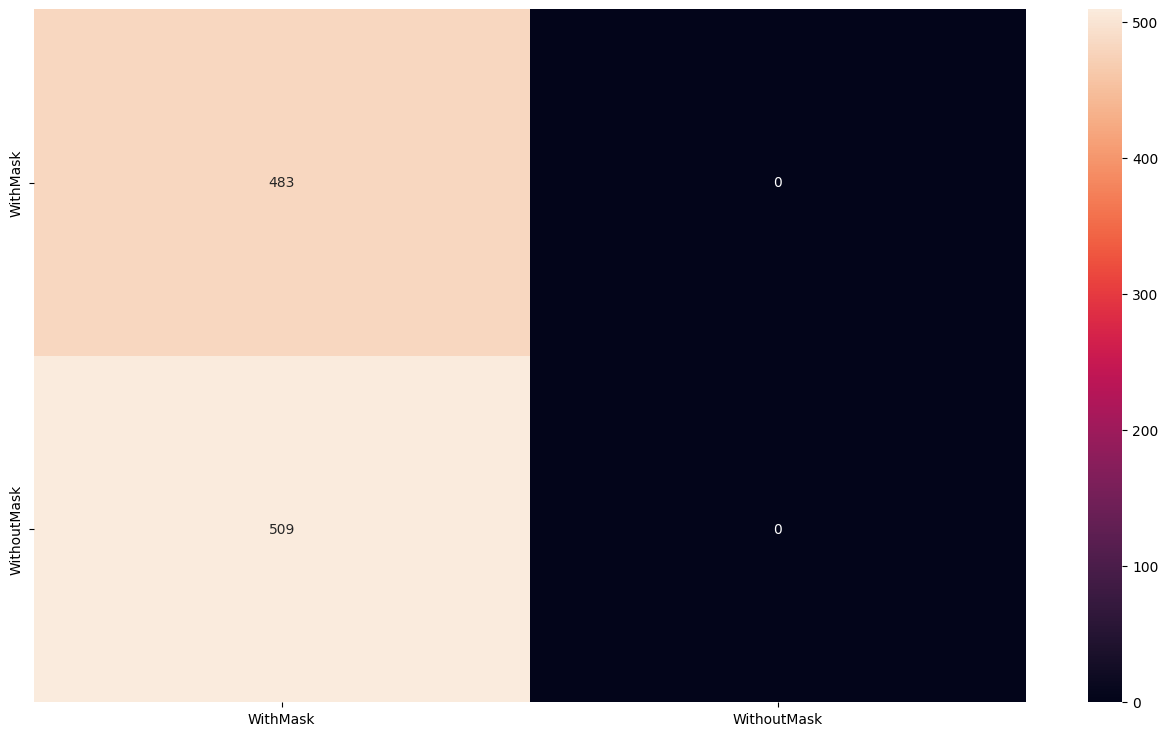

In [23]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (16,9))
y_pred_labels = [ np.argmax(label) for label in y_pred ]
cm = confusion_matrix(test_generator.classes,y_pred_labels)

sns.heatmap(cm,annot = True , fmt = 'd' ,xticklabels = training_data.class_indices,yticklabels=training_data.class_indices)